# Library

In [1]:
import math
import random
import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
%matplotlib inline
print('Loaded 1')


exec(open('utils.py').read())
print('Loaded 2')

Loaded 1
Loaded 2


In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 100*K                                      # Number of runs to do (default 100*K)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)


years = range(CURRENT_YEAR, MAX_YEAR)
print('Loaded')


Loaded


# Model

### TAI Scenarios

In [3]:
# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making agentic TAI, will it be aligned by default?
p_tai_aligned_by_default = 0.1

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(war, year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(0.05 + 1.15 * (year/45), 0.75)
    else:
        p = min(0.05 + 1.5 * (year/45), 0.85)
    if war:
        p = p * 0.7
    if verbose == 2:
        print('* alignment diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
# TODO: Convert to logistic curves

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved_if_aligned_by_default = 0.65

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
p_full_tai_misalignment_averted = 0.15

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
p_tai_misalignment_averting_is_catastrophic = 0.4

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
p_full_tai_misalignment_averted_means_abandoned_tai = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
p_tai_xrisk_is_extinction = 0.4

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
p_tai_singleton_is_catastrophic = 0.8


exec(open('modules/tai.py').read())
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


### Nuclear Scenarios Module

In [4]:
def p_russia_uses_nuke(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return 0.05 / 2
    else:
        return 0.001 / peace

    
p_nk_uses_nuke = 0.001


def p_china_invades_taiwan(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022:
        return 0
    elif year == 2023:
        return 0.03
    elif year == 2024:
        return 0.145 # makes cumulative probability by EOY 2025 = 0.17 (0.03 + 0.145*(1-0.03) = 0.17)
    elif year < 2030:
        return 0.096 # makes cumulative probability by EOY 2029 = 0.5
                     # 0.17 + (1-0.17)*X + (1-0.17)(1-X)*X + (1-0.17)(1-X)^2*X + (1-0.17)(1-X)^3*X + (1-0.17)(1-X)^4*X = 0.5
    elif year < 2035:
        return 0.097 # makes cumulative probability by EOY 2034 = 0.7
                     # 0.5 + (1-0.5)*X + (1-0.5)(1-X)*X + (1-0.5)(1-X)^2*X + (1-0.5)(1-X)^3*X + (1-0.5)(1-X)^4*X = 0.7
    else:
        return 0.005 / peace


def p_china_uses_nuke(peace, year):
    return p_china_invades_taiwan(peace, year) * 0.01

    
def p_other_uses_nuke(peace):
    peace = 10 if peace else 1
    return 0.0002 / peace


# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.05 if war else 0.02
    p = p * (0.998 ** year)
    return p


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.6 if war else 0.3
    p_nuclear_winter_happens = 0.3
    alternative_foods_or_other_save = 0.05
    return (p_exchange_becomes_all_out_war *
            (p_nuclear_winter_happens + (1 - p_nuclear_winter_happens) * 0.1) *
            (1 - alternative_foods_or_other_save))
    
    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
p_xrisk_from_nuclear_catastrophe = 0.05 # https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
def p_nuclear_exchange_given_war(first_year_of_war):
    return 0.1 if first_year_of_war else 0.02


exec(open('modules/nuclear.py').read())
print('Loaded nuclear scenarios module')


Loaded nuclear scenarios module


### Great Power War Scenarios Module

In [5]:
def p_great_power_war_us_russia_without_nuke_first(peace, year):
    peace = 20 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return (0.02 / 2) / peace
    else:
        return 0.003 / peace

    
def p_great_power_war_us_china(peace, year):
    peace = 20 if peace else 1
    p_invade_taiwan = p_china_invades_taiwan(peace, year)
    p_us_responds = 0.6
    return p_invade_taiwan * p_us_responds

    
def p_great_power_war_other(peace, year):
    peace = 5 if peace else 1
    year = year + CURRENT_YEAR
    if year > 2040:
        return 0.005 / peace
    else:
        return 0.001 / peace


# Conditional on a great power war starting, how long will it last?
war_length = sq.lognorm(2, 50) # 90% CI

# After a war ends, how long will there be a peace?
peace_length = sq.lognorm(10, 100)


exec(open('modules/great_power_war.py').read())
print('Loaded great power war scenarios module')


Loaded great power war scenarios module


### Bio scenarios module

In [6]:
# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
p_biowar_given_war = 1/800

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
p_nonstate_bio = 1/1200

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
p_natural_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
p_engineered_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

p_covid_spanish_flu_like_becomes_1pct_death = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
p_covid_lab_leak = 0.3
p_extinction_given_90_pct_death = 0.03 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
p_accidental_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
p_intentional_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
ratio_engineered_vs_natural_lab_leak = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year):
    base_rate_from_covid_and_spanish_flu = 1/250
    increase_from_globalization = 1.1
    decreate_in_rate_per_year_from_improvements = 0.99 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - p_covid_lab_leak) * 0.5) *
            increase_from_globalization *
            p_covid_spanish_flu_like_becomes_1pct_death *
            decreate_in_rate_per_year_from_improvements)
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    base_rate_from_covid = 0.01 * p_covid_lab_leak
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         p_covid_spanish_flu_like_becomes_1pct_death *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
    

# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year):
    return p_accidental_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year):
    return p_intentional_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


exec(open('modules/bio.py').read())
print('Loaded bio scenarios module')


Loaded bio scenarios module


### Nanotech scenarios module

In [7]:
# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1


# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1 * 0.05


exec(open('modules/nano.py').read())
print('Loaded nano scenarios module')


Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [8]:
p_supervolcano_catastrophe = 1 / (500*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/ VEI >= 9 (geometric mean of 30K and 30M)

p_supervolcano_extinction_given_catastrophe = 0.05


exec(open('modules/supervolcano.py').read())
print('Loaded supervolcano module')


Loaded supervolcano module


### Unknown unknown scenarios module

In [9]:
# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return (1 / (100*K)) / (0.99 ** year) # TODO: This goes over 1


p_extinction_from_double_catastrophe = 0.1
extinction_from_double_catastrophe_range = 10
    
    
exec(open('modules/unknown_unknown.py').read())
print('Loaded unknown unknown scenarios module')


Loaded unknown unknown scenarios module


### AI Timeline variables

In [10]:
## AI TIMELINE VARIABLES

def sample_tai_log_flop_needs(brain, efficiency, transformative_vs_human, horizon_length, scaling_exponent,
                              flops_per_param_per_sec, params=None, ref_params=11.2, ref_params_samples=12,
                              bayes_update=None, debug=False):
    # Debug = 1 for just printing parameters
    # Debug = 2 for just printing the equation
    # Debug = True or debug = 3 for printing both
    
    if bayes_update is None:
        bayes_update = lambda x: x
    
    brain_ = sq.sample(brain)
    eff_ = sq.sample(efficiency)
    tvh_ = sq.sample(transformative_vs_human)
    h_ = sq.sample(horizon_length)
    e_ = sq.sample(scaling_exponent)
    fpp_ = sq.sample(flops_per_param_per_sec)
    
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('Anchor debug:')
        
    if debug is True or debug == 1 or debug == 3:
        print('-- Assume human brain in inference takes {} log FLOP (i.e., 10^{} FLOP)'.format(round(brain_, 1),
                                                                                               round(brain_, 1)))
        print('-- Add {} log FLOP for efficiency'.format(round(eff_, 1)))
        print('-- Assume a transformative model takes {} log FLOP compared to human'.format(round(tvh_, 1)))
        print('-- Assume a horizon length of {}'.format(round(h_, 1)))
        print('-- Assume a scaling exponent of {}'.format(round(e_, 3)))
        print('-- Assume FLOPs per param per sec of {}'.format(round(fpp_, 1)))
    
    if params is None:
        params_ = brain_ + eff_ - fpp_        
    else:
        params_ = ~params
    
    out = brain_ + eff_ + tvh_ + h_ + ref_params_samples - e_ * ref_params + e_ * params_
    
    if debug is True or debug == 2 or debug == 3:
        if params is None:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * ({round(brain_, 1)} + {round(eff_, 1)} - {round(fpp_, 1)})")
        else:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * {round(params_, 2)}")
    
    out = bayes_update(out)
    if debug is True or debug == 2 or debug == 3:
        print('-- {} after Bayes update'.format(round(out, 1)))
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('-')

    return out


def wildeford_bayes_update_against_low_flop(f):
    f = f + sq.norm(1,3) if f < 27 and sq.event(p=0.1) else f
    f = f + sq.norm(1,3) if f < 26 and sq.event(p=0.2) else f
    f = f + sq.norm(1,3) if f < 25 and sq.event(p=0.6) else f
    f = f + sq.norm(1,3) if f < 24 and sq.event(p=0.8) else f
    return sq.sample(f)


def wildeford_meta_anchor(efficiency, debug=False):
    horizon_length = sq.mixture([[0.4, 0],
                                 [0.2, sq.norm(0,3)],
                                 [0.25, sq.lognorm(3,7)],
                                 [0.15, sq.norm(7,11)]],
                                lclip=0)
    
    return sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=efficiency,
                                     transformative_vs_human=sq.norm(-2,1),
                                     horizon_length=horizon_length,
                                     scaling_exponent=sq.norm(0.5,1.5),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=wildeford_bayes_update_against_low_flop,
                                     debug=debug)


def max_gdp_frac(war):
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/500, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if (not war and r_ < 0.3) or (war and r_ < 0.05):
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.2,0.6, lclip=0.1, rclip=0.9)
    elif (not war and r_ < 0.9) or (war and r_ < 0.4):
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.4,0.7, lclip=0.1, rclip=0.9)
    elif not war or (war and r_ < 0.9):
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5,0.9, lclip=0.1, rclip=0.9)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.6,0.9, lclip=0.1, rclip=0.9)
        
    return gdp_frac * percent_spent_on_compute


initial_gdp = 21.3*T

initial_flops_per_dollar = 18

tai_flop_size = wildeford_meta_anchor

flops_halving_rate = sq.lognorm(2, 5)

initial_pay = sq.mixture([[0.8, 7.1],
                          [0.2, sq.lognorm(7.1,9, lclip=7.1)]])

max_flops_per_dollar = 24

gdp_growth = sq.lognorm(1.015, 1.035) #NEW

spend_doubling_time = sq.mixture([[0.8, sq.lognorm(3,6)],
                                  [0.2, sq.lognorm(1,2, lclip=1)]])
# TODO: Willingness to spend connected to commercialization

initial_chance_of_nonscaling_issue = 0.95
final_chance_of_nonscaling_issue = 0.3 #NEW
nonscaling_issue_bottom_year = 2050
nonscaling_delay = sq.mixture([[0.7, sq.lognorm(2,10)],
                               [0.3, sq.lognorm(5,40)]]) #NEW

algo_doubling_rate_max = sq.norm(1,3) # NEW
algo_doubling_rate_min = sq.norm(1,2) # NEW

efficiency = sq.mixture([[0.1, 0],
                          [0.9, sq.lognorm(1,4)]])

use_efficiency_based_algo_reduction = True
efficiency_based_additional_reduction = sq.mixture([[0.4, 0],
                                                    [0.6, sq.norm(0,2)]]) # NEW

p_willingness_ramp = 0

willingness_spend_horizon = 1

tai_china_war_delay_yrs = sq.norm(2,6)
tai_china_war_delay_end_year = 2040

tai_catastrophe_delay_yrs = sq.lognorm(4,20)

# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)


def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 650:
        y = math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x))
        if y > 300:
            y = int(y) # Handle overflow errors
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)
    

def algo_halving_fn(min_speed, max_speed, tai_flop_size):
    if max_speed < min_speed:
        max_speed = min_speed
    if min_speed > max_speed:
        min_speed = max_speed
    return min(max(max_speed - (round((tai_flop_size - 29) / 2) / 2), min_speed), max_speed)


def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 650:
        y = (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
        if y > 300:
            y = int(y) # Handle overflow errors        
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

    
def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 650:
        y = (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
        if y > 300:
            y = int(y) # Handle overflow errors                
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

    
def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    if max_reduction < min_reduction:
        max_reduction = min_reduction
    if min_reduction > max_reduction:
        min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)


# NEW
def p_nonscaling_delay(initial_p, final_p, year, max_year):
    return generalized_logistic_curve(x=year - CURRENT_YEAR,
                                      slope=0.3,
                                      shift=3 * (max_year - CURRENT_YEAR),
                                      push=1,
                                      maximum=final_p,
                                      minimum=initial_p)


print('Loaded')


Loaded


### Overall module structure

In [11]:
sq.get_percentiles(max_gdp_frac(war=True) @ 1000)

{1: 0.0009060510734423077,
 5: 0.0012134131608470722,
 10: 0.0014455765824611237,
 20: 0.001695295245476578,
 30: 0.0019789308753276253,
 40: 0.0022019140554136035,
 50: 0.002463988941133353,
 60: 0.002756629677346868,
 70: 0.0031210119229847515,
 80: 0.0035098402011151065,
 90: 0.004100262760079769,
 95: 0.004766696105738611,
 99: 0.005882602153217269}

In [12]:
sq.get_percentiles(max_gdp_frac(war=False) @ 1000)

{1: 0.0004047759774534768,
 5: 0.0004680164161605226,
 10: 0.0005044457733731888,
 20: 0.0005592733827800278,
 30: 0.0006000128670210599,
 40: 0.0006459496024796106,
 50: 0.0006867430105103776,
 60: 0.0007242127074595631,
 70: 0.0007676004360065592,
 80: 0.0008204252970915442,
 90: 0.0009009011816350047,
 95: 0.0009635093186514092,
 99: 0.0010974375508443345}

In [13]:
sq.get_percentiles([int(round(x)) for x in tai_china_war_delay_yrs @ 1000])

{1: 1.0,
 5: 2.0,
 10: 2.0,
 20: 3.0,
 30: 3.0,
 40: 4.0,
 50: 4.0,
 60: 4.0,
 70: 5.0,
 80: 5.0,
 90: 6.0,
 95: 6.0,
 99: 7.0}

In [14]:
sq.get_percentiles([int(round(x)) for x in tai_catastrophe_delay_yrs @ 1000])

{1: 3.0,
 5: 4.0,
 10: 5.0,
 20: 6.0,
 30: 7.0,
 40: 8.0,
 50: 9.0,
 60: 10.0,
 70: 12.0,
 80: 14.0,
 90: 17.0,
 95: 20.0,
 99: 28.0}

In [15]:
exec(open('modules/define_event.py').read())
print('Model loaded')


Model loaded


Anchor debug:
-- Assume human brain in inference takes 14.0 log FLOP (i.e., 10^14.0 FLOP)
-- Add 3.0 log FLOP for efficiency
-- Assume a transformative model takes 0.2 log FLOP compared to human
-- Assume a horizon length of 4.8
-- Assume a scaling exponent of 0.902
-- Assume FLOPs per param per sec of 1.8
-- 37.6 = 14.0 + 3.0 + 0.2 + 4.8 + 12 - 0.902 * 11.2 + 0.902 * (14.0 + 3.0 - 1.8)
-- 37.6 after Bayes update
-
...TAI setup complete in 3.52ms
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 37.6 log FLOPs (~37 thousand decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 4.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.4x per year to a max of 0.00054% of GDP. GDP grows at a rate of 1.019x per year.
I

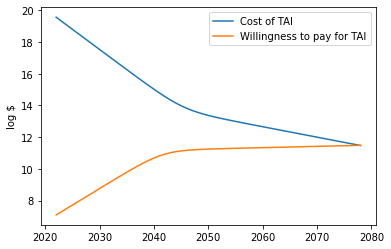

2078: ...XRISK from intentional misuse of TAI (singleton) :(
...Singleton is catastrophic
...Total loop complete in 133.49ms
-
-
{'collectors': {2022: {'averted_misalignment': False,
                       'catastrophe': [],
                       'category': 'boring',
                       'china_nuke_first': False,
                       'double_catastrophe_xrisk': None,
                       'engineered_pathogen': False,
                       'final_year': None,
                       'nano': False,
                       'natural_pathogen': False,
                       'nuclear_weapon_used': False,
                       'peace_until': None,
                       'recent_catastrophe_year': None,
                       'russia_nuke_first': False,
                       'tai': False,
                       'tai_type': None,
                       'tai_year': None,
                       'terminate': False,
                       'war': False,
                       'war_belliger

                       'tai': True,
                       'tai_type': 'agent',
                       'tai_year': 2078,
                       'terminate': True,
                       'war': True,
                       'war_belligerents': 'US/Russia',
                       'war_end_year': 2089,
                       'war_start_year': 2030,
                       'wars': [{'belligerents': 'US/Russia',
                                 'end_year': 2089,
                                 'start_year': 2030,
                                 'war_length': 59}]},
                2182: {'averted_misalignment': False,
                       'catastrophe': ['xrisk_tai_misuse'],
                       'category': 'xrisk_tai_misuse',
                       'china_nuke_first': False,
                       'double_catastrophe_xrisk': None,
                       'engineered_pathogen': False,
                       'final_year': 2078,
                       'nano': False,
                       

In [16]:
pprint(define_event(verbosity=4))

2031: WAR!!! (US vs. China)
--- /!\ TAI CREATED in 2039


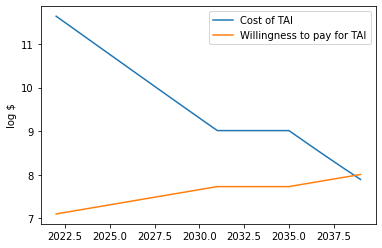

2039: ...Tool TAI made
2040: War ends :)
2198: North Korea uses a nuke first strike!
2205: WAR!!! (US vs. Russia)
2221: War ends :)
...Boring future
-
-


In [17]:
define_event(verbosity=1); None

-
-
############
## RUN 1 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.3 log FLOP (i.e., 10^16.3 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.989
-- Assume FLOPs per param per sec of 1.6
-- 34.9 = 16.3 + 2.1 + -0.9 + 0 + 12 - 0.989 * 11.2 + 0.989 * (16.3 + 2.1 - 1.6)
-- 34.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 34.9 log FLOPs (~71 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.1x per year to a max of 0.00047% of GDP. GDP grows at a rate of 1.031x per year.
If

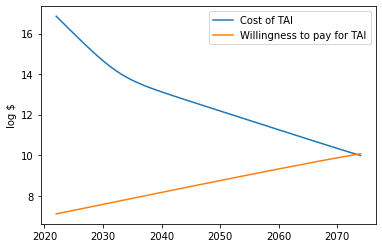

2074: ...Tool TAI made
2075: War ends :)
2115: ...catastrophe from lab-leak engineered pathogen
2128: WAR!!! (US vs. Russia)
2138: War ends :)
...Boring future
-
-
-
-
############
## RUN 2 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.7 log FLOP (i.e., 10^11.7 FLOP)
-- Add 3.7 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 2.9
-- Assume a scaling exponent of 1.247
-- Assume FLOPs per param per sec of 1.9
-- 33.0 = 11.7 + 3.7 + -0.2 + 2.9 + 12 - 1.247 * 11.2 + 1.247 * (11.7 + 3.7 - 1.9)
-- 33.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.0 log FLOPs (~961 nonillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 4.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2

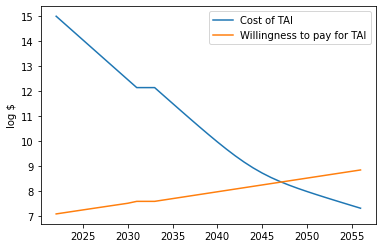

2056: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 3 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.9 log FLOP (i.e., 10^14.9 FLOP)
-- Add 1.1 log FLOP for efficiency
-- Assume a transformative model takes -0.1 log FLOP compared to human
-- Assume a horizon length of 4.4
-- Assume a scaling exponent of 1.214
-- Assume FLOPs per param per sec of 1.3
-- 36.6 = 14.9 + 1.1 + -0.1 + 4.4 + 12 - 1.214 * 11.2 + 1.214 * (14.9 + 1.1 - 1.3)
-- 36.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.6 log FLOPs (~4 thousand decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.9 log 2022$USD (~81 million) and this 

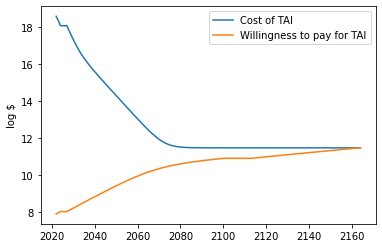

2164: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 4 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.9 log FLOP (i.e., 10^12.9 FLOP)
-- Add 1.1 log FLOP for efficiency
-- Assume a transformative model takes -0.1 log FLOP compared to human
-- Assume a horizon length of 1.4
-- Assume a scaling exponent of 0.966
-- Assume FLOPs per param per sec of 1.6
-- 28.2 = 12.9 + 1.1 + -0.1 + 1.4 + 12 - 0.966 * 11.2 + 0.966 * (12.9 + 1.1 - 1.6)
-- 28.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 28.2 log FLOPs (~17 octillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.8 log 2022$USD (~58 million) and this increase

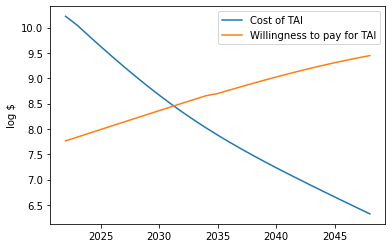

2048: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 5 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.7 log FLOP (i.e., 10^14.7 FLOP)
-- Add 1.3 log FLOP for efficiency
-- Assume a transformative model takes 0.0 log FLOP compared to human
-- Assume a horizon length of 0.8
-- Assume a scaling exponent of 0.93
-- Assume FLOPs per param per sec of 1.5
-- 31.9 = 14.7 + 1.3 + 0.0 + 0.8 + 12 - 0.93 * 11.2 + 0.93 * (14.7 + 1.3 - 1.5)
-- 31.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 31.9 log FLOPs (~73 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 

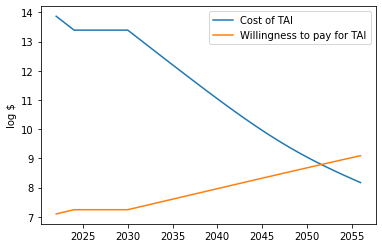

2056: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 6 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.3 log FLOP (i.e., 10^15.3 FLOP)
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 2.6
-- Assume a scaling exponent of 0.659
-- Assume FLOPs per param per sec of 1.5
-- 33.6 = 15.3 + 1.6 + -0.6 + 2.6 + 12 - 0.659 * 11.2 + 0.659 * (15.3 + 1.6 - 1.5)
-- 33.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.6 log FLOPs (~4 decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases

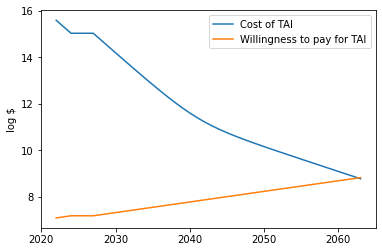

2063: ...Tool TAI made
2122: WAR!!! (US vs. Russia)
2136: War ends :)
...Boring future
-
-
-
-
############
## RUN 7 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.6 log FLOP (i.e., 10^15.6 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.114
-- Assume FLOPs per param per sec of 1.5
-- 34.1 = 15.6 + 1.8 + -0.6 + 0 + 12 - 1.114 * 11.2 + 1.114 * (15.6 + 1.8 - 1.5)
-- 34.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 34.1 log FLOPs (~12 decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increas

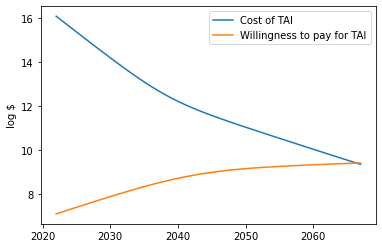

2067: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 8 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.3 log FLOP (i.e., 10^13.3 FLOP)
-- Add 2.9 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 7.9
-- Assume a scaling exponent of 1.708
-- Assume FLOPs per param per sec of 1.5
-- 41.4 = 13.3 + 2.9 + -0.8 + 7.9 + 12 - 1.708 * 11.2 + 1.708 * (13.3 + 2.9 - 1.5)
-- 41.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 41.4 log FLOPs (~251 million decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this

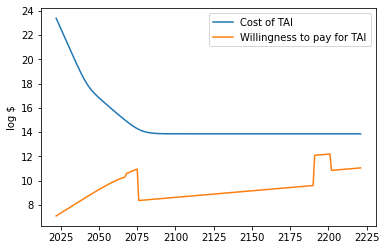

-
-
-
-
############
## RUN 9 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.1 log FLOP (i.e., 10^17.1 FLOP)
-- Add 0.8 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 8.4
-- Assume a scaling exponent of 0.633
-- Assume FLOPs per param per sec of 1.5
-- 40.9 = 17.1 + 0.8 + -0.7 + 8.4 + 12 - 0.633 * 11.2 + 0.633 * (17.1 + 0.8 - 1.5)
-- 40.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 40.9 log FLOPs (~73 million decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 0.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.2x per year to a max of 0.00052% of GDP. GDP grows at a rate of 1.0

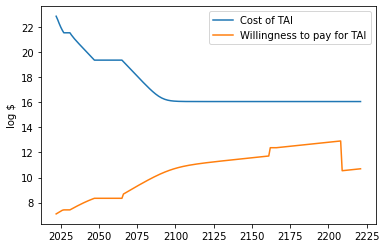

-
-
-
-
############
## RUN 10 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.1 log FLOP (i.e., 10^14.1 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -2.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.155
-- Assume FLOPs per param per sec of 1.6
-- 29.8 = 14.1 + 2.1 + -2.3 + 0 + 12 - 1.155 * 11.2 + 1.155 * (14.1 + 2.1 - 1.6)
-- 29.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 29.8 log FLOPs (~696 octillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 6.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.5x per year to a max of 0.00039% of GDP. GDP grows at a rate of 1.02x per yea

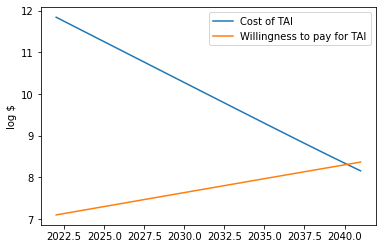

2041: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 11 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.3 log FLOP (i.e., 10^15.3 FLOP)
-- Add 2.4 log FLOP for efficiency
-- Assume a transformative model takes -1.0 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.445
-- Assume FLOPs per param per sec of 1.7
-- 35.7 = 15.3 + 2.4 + -1.0 + 0 + 12 - 1.445 * 11.2 + 1.445 * (15.3 + 2.4 - 1.7)
-- 35.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 35.7 log FLOPs (~447 decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases 

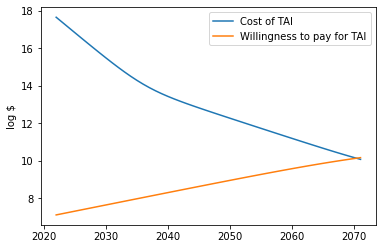

2071: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 12 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.6 log FLOP (i.e., 10^12.6 FLOP)
-- Add 2.4 log FLOP for efficiency
-- Assume a transformative model takes -1.4 log FLOP compared to human
-- Assume a horizon length of 8.4
-- Assume a scaling exponent of 0.656
-- Assume FLOPs per param per sec of 0.9
-- 36.0 = 12.6 + 2.4 + -1.4 + 8.4 + 12 - 0.656 * 11.2 + 0.656 * (12.6 + 2.4 - 0.9)
-- 36.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.0 log FLOPs (~1 thousand decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 4.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this

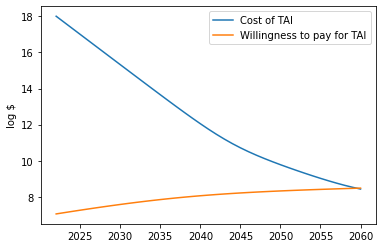

2060: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 13 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.2 log FLOP (i.e., 10^15.2 FLOP)
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 0.3
-- Assume a scaling exponent of 1.201
-- Assume FLOPs per param per sec of 1.3
-- 33.6 = 15.2 + 1.4 + -0.2 + 0.3 + 12 - 1.201 * 11.2 + 1.201 * (15.2 + 1.4 - 1.3)
-- 33.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.6 log FLOPs (~4 decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increase

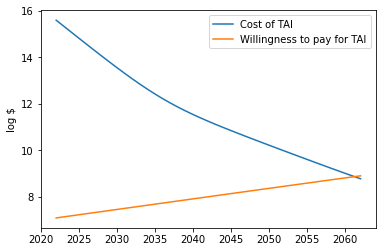

2062: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 14 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.8 log FLOP (i.e., 10^16.8 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.9
-- Assume FLOPs per param per sec of 1.5
-- 36.8 = 16.8 + 2.1 + 0.3 + 0 + 12 - 0.9 * 11.2 + 0.9 * (16.8 + 2.1 - 1.5)
-- 36.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.8 log FLOPs (~7 thousand decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases b

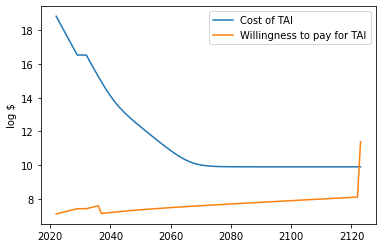

2123: ...XRISK from intentional misuse of TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 15 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.2 log FLOP (i.e., 10^16.2 FLOP)
-- Add 1.3 log FLOP for efficiency
-- Assume a transformative model takes -1.1 log FLOP compared to human
-- Assume a horizon length of 2.8
-- Assume a scaling exponent of 1.061
-- Assume FLOPs per param per sec of 1.7
-- 36.2 = 16.2 + 1.3 + -1.1 + 2.8 + 12 - 1.061 * 11.2 + 1.061 * (16.2 + 1.3 - 1.7)
-- 36.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.2 log FLOPs (~1 thousand decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) 

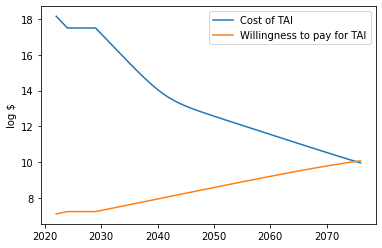

2076: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 16 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.1 log FLOP (i.e., 10^15.1 FLOP)
-- Add 2.8 log FLOP for efficiency
-- Assume a transformative model takes 0.1 log FLOP compared to human
-- Assume a horizon length of 5.6
-- Assume a scaling exponent of 1.276
-- Assume FLOPs per param per sec of 1.5
-- 42.4 = 15.1 + 2.8 + 0.1 + 5.6 + 12 - 1.276 * 11.2 + 1.276 * (15.1 + 2.8 - 1.5)
-- 42.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 42.4 log FLOPs (~3 billion decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 4.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.0 log 2022$USD (~100 million) and this i

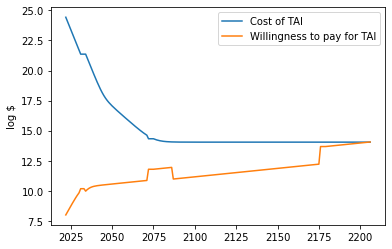

2206: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 17 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.2 log FLOP (i.e., 10^16.2 FLOP)
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes -0.0 log FLOP compared to human
-- Assume a horizon length of 3.8
-- Assume a scaling exponent of 1.386
-- Assume FLOPs per param per sec of 1.4
-- 41.0 = 16.2 + 1.7 + -0.0 + 3.8 + 12 - 1.386 * 11.2 + 1.386 * (16.2 + 1.7 - 1.4)
-- 41.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 41.0 log FLOPs (~94 million decillion) for transformative capabilities.
Every 1.1 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this

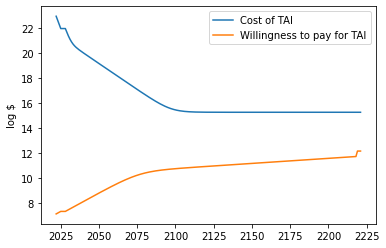

-
-
-
-
############
## RUN 18 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.7 log FLOP (i.e., 10^11.7 FLOP)
-- Add 1.0 log FLOP for efficiency
-- Assume a transformative model takes 0.2 log FLOP compared to human
-- Assume a horizon length of 4.2
-- Assume a scaling exponent of 1.08
-- Assume FLOPs per param per sec of 2.4
-- 27.9 = 11.7 + 1.0 + 0.2 + 4.2 + 12 - 1.08 * 11.2 + 1.08 * (11.7 + 1.0 - 2.4)
-- 27.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 27.9 log FLOPs (~8 octillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 1.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.6x per year to a max of 0.00077% of GDP. GDP grows at a rate of 1.025x per year.

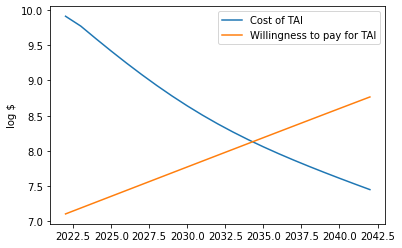

2042: ...Achieved aligned TAI (aligned by default), happy future! :D
-
-
-
-
############
## RUN 19 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.0 log FLOP (i.e., 10^14.0 FLOP)
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.112
-- Assume FLOPs per param per sec of 1.3
-- 29.9 = 14.0 + 1.4 + -0.7 + 0 + 12 - 1.112 * 11.2 + 1.112 * (14.0 + 1.4 - 1.3)
-- 29.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 29.9 log FLOPs (~857 octillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.3x per y

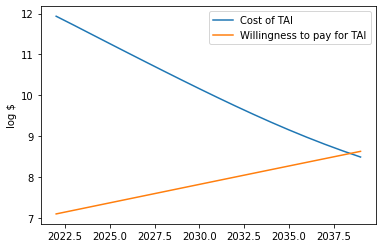

2039: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 20 ##
############
Anchor debug:
-- Assume human brain in inference takes 20.1 log FLOP (i.e., 10^20.1 FLOP)
-- Add 2.2 log FLOP for efficiency
-- Assume a transformative model takes -1.2 log FLOP compared to human
-- Assume a horizon length of 9.4
-- Assume a scaling exponent of 1.366
-- Assume FLOPs per param per sec of 1.5
-- 55.5 = 20.1 + 2.2 + -1.2 + 9.4 + 12 - 1.366 * 11.2 + 1.366 * (20.1 + 2.2 - 1.5)
-- 55.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 55.5 log FLOPs (~33 sextillion decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 2.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and t

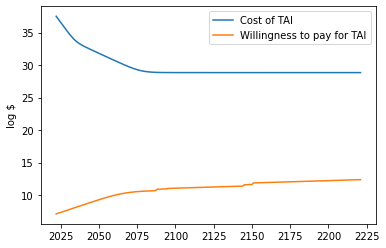

-
-
-
-
############
## RUN 21 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.9 log FLOP (i.e., 10^14.9 FLOP)
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -1.4 log FLOP compared to human
-- Assume a horizon length of 4.4
-- Assume a scaling exponent of 0.874
-- Assume FLOPs per param per sec of 1.6
-- 34.5 = 14.9 + 1.5 + -1.4 + 4.4 + 12 - 0.874 * 11.2 + 0.874 * (14.9 + 1.5 - 1.6)
-- 34.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 34.5 log FLOPs (~32 decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 2.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.4 log 2022$USD (~25 million) and this increases by 4.9x per year to a max of 0.00055% of GDP. GDP grows at a rate of 1.022x per

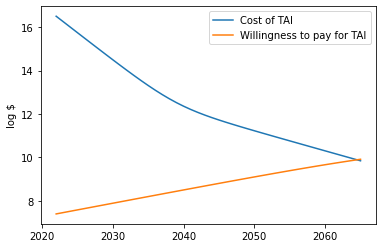

2065: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 22 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.3 log FLOP (i.e., 10^18.3 FLOP)
-- Add 2.4 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.031
-- Assume FLOPs per param per sec of 1.9
-- 40.2 = 18.3 + 2.4 + -0.3 + 0 + 12 - 1.031 * 11.2 + 1.031 * (18.3 + 2.4 - 1.9)
-- 40.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 40.2 log FLOPs (~17 million decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this inc

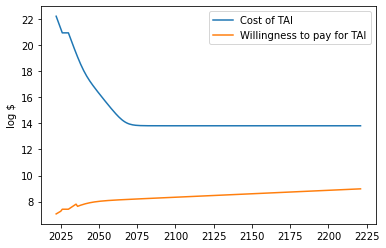

-
-
-
-
############
## RUN 23 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.6 log FLOP (i.e., 10^14.6 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -1.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.281
-- Assume FLOPs per param per sec of 1.1
-- 33.1 = 14.6 + 2.1 + -1.2 + 0 + 12 - 1.281 * 11.2 + 1.281 * (14.6 + 2.1 - 1.1)
-- 33.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.1 log FLOPs (~1 decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.5x per year to a max of 3e-05% of GDP. GDP grows at a rate of 1.025x per year.


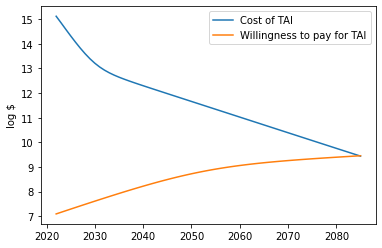

2085: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 24 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.8 log FLOP (i.e., 10^15.8 FLOP)
-- Add 2.7 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.835
-- Assume FLOPs per param per sec of 1.8
-- 40.1 = 15.8 + 2.7 + -0.7 + 0 + 12 - 1.835 * 11.2 + 1.835 * (15.8 + 2.7 - 1.8)
-- 40.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 40.1 log FLOPs (~11 million decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 4.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.9 log 2022$USD (~84 million) and this inc

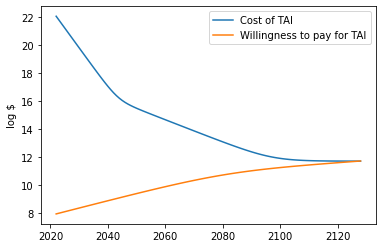

2128: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 25 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.4 log FLOP (i.e., 10^17.4 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.798
-- Assume FLOPs per param per sec of 1.8
-- 35.3 = 17.4 + 1.8 + -0.9 + 0 + 12 - 0.798 * 11.2 + 0.798 * (17.4 + 1.8 - 1.8)
-- 35.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 35.3 log FLOPs (~178 decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.0 log 2022$USD (~106 million) and this increases

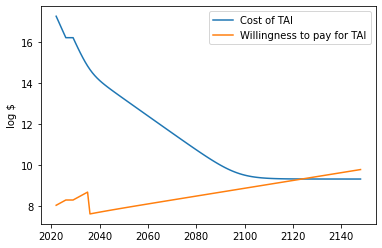

2148: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 26 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.4 log FLOP (i.e., 10^17.4 FLOP)
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.021
-- Assume FLOPs per param per sec of 1.6
-- 36.8 = 17.4 + 1.7 + -0.7 + 0 + 12 - 1.021 * 11.2 + 1.021 * (17.4 + 1.7 - 1.6)
-- 36.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.8 log FLOPs (~7 thousand decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.0 log 2022$USD (~101 million) and this in

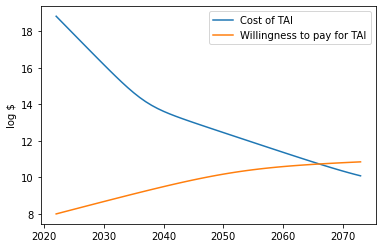

2073: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 27 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.4 log FLOP (i.e., 10^12.4 FLOP)
-- Add 2.2 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.539
-- Assume FLOPs per param per sec of 1.0
-- 30.2 = 12.4 + 2.2 + -0.2 + 0 + 12 - 1.539 * 11.2 + 1.539 * (12.4 + 2.2 - 1.0)
-- 30.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 30.2 log FLOPs (~1 nonillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by

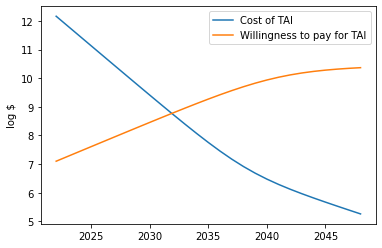

2048: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 28 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.3 log FLOP (i.e., 10^17.3 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -1.0 log FLOP compared to human
-- Assume a horizon length of 3.3
-- Assume a scaling exponent of 1.189
-- Assume FLOPs per param per sec of 1.7
-- 40.9 = 17.3 + 1.8 + -1.0 + 3.3 + 12 - 1.189 * 11.2 + 1.189 * (17.3 + 1.8 - 1.7)
-- 40.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 40.9 log FLOPs (~73 million decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.7x per year to a max o

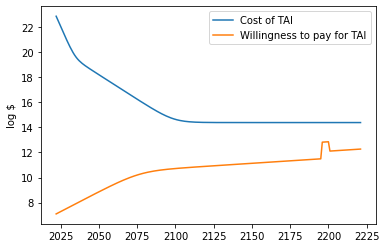

-
-
-
-
############
## RUN 29 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.8 log FLOP (i.e., 10^13.8 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.334
-- Assume FLOPs per param per sec of 1.7
-- 26.1 = 13.8 + 0 + -0.9 + 0 + 12 - 1.334 * 11.2 + 1.334 * (13.8 + 0 - 1.7)
-- 26.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 26.1 log FLOPs (~139 septillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 0.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.0x per year to a max of 0.00114% of GDP. GDP grows at a rate of 1.022x per year.
I

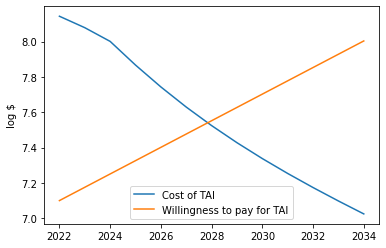

2034: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 30 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.9 log FLOP (i.e., 10^16.9 FLOP)
-- Add 1.1 log FLOP for efficiency
-- Assume a transformative model takes 0.5 log FLOP compared to human
-- Assume a horizon length of 2.0
-- Assume a scaling exponent of 1.097
-- Assume FLOPs per param per sec of 2.2
-- 37.6 = 16.9 + 1.1 + 0.5 + 2.0 + 12 - 1.097 * 11.2 + 1.097 * (16.9 + 1.1 - 2.2)
-- 37.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 37.6 log FLOPs (~38 thousand decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 0.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.0x per year to a max of

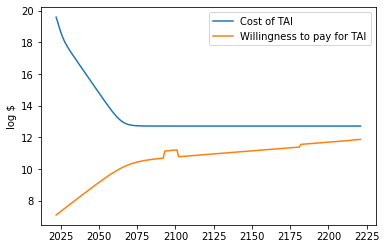

-
-
-
-
############
## RUN 31 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.8 log FLOP (i.e., 10^18.8 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -1.9 log FLOP compared to human
-- Assume a horizon length of 5.3
-- Assume a scaling exponent of 0.677
-- Assume FLOPs per param per sec of 2.0
-- 38.0 = 18.8 + 0 + -1.9 + 5.3 + 12 - 0.677 * 11.2 + 0.677 * (18.8 + 0 - 2.0)
-- 38.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 38.0 log FLOPs (~110 thousand decillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.8 log 2022$USD (~70 million) and this increases by 4.5x per year to a max of 0.00072% of GDP. GDP grows at a rate of 1.02x pe

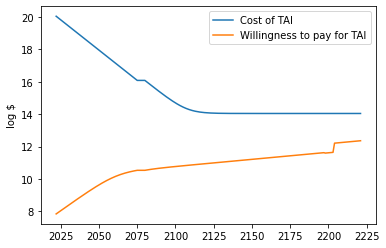

-
-
-
-
############
## RUN 32 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.2 log FLOP (i.e., 10^16.2 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -1.2 log FLOP compared to human
-- Assume a horizon length of 1.7
-- Assume a scaling exponent of 0.456
-- Assume FLOPs per param per sec of 1.6
-- 30.2 = 16.2 + 0 + -1.2 + 1.7 + 12 - 0.456 * 11.2 + 0.456 * (16.2 + 0 - 1.6)
-- 30.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 30.2 log FLOPs (~2 nonillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.6x per year to a max of 0.0017% of GDP. GDP grows at a rate of 1.012x per year.
I

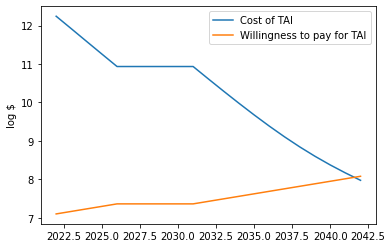

2042: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 33 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.6 log FLOP (i.e., 10^16.6 FLOP)
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.725
-- Assume FLOPs per param per sec of 1.7
-- 33.5 = 16.6 + 1.8 + -0.8 + 0 + 12 - 0.725 * 11.2 + 0.725 * (16.6 + 1.8 - 1.7)
-- 33.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.5 log FLOPs (~3 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.5x per year to a max of 0.00054% of

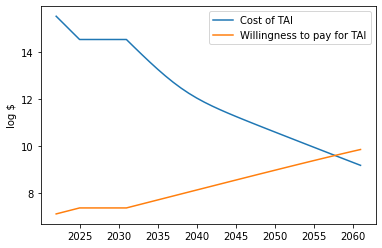

2061: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 34 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.9 log FLOP (i.e., 10^12.9 FLOP)
-- Add 3.2 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 4.8
-- Assume a scaling exponent of 0.854
-- Assume FLOPs per param per sec of 1.4
-- 36.1 = 12.9 + 3.2 + 0.3 + 4.8 + 12 - 0.854 * 11.2 + 0.854 * (12.9 + 3.2 - 1.4)
-- 36.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.1 log FLOPs (~1 thousand decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this i

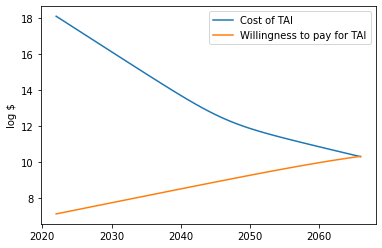

2066: ...XRISK from intentional misuse of TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 35 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.8 log FLOP (i.e., 10^15.8 FLOP)
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -2.2 log FLOP compared to human
-- Assume a horizon length of 9.4
-- Assume a scaling exponent of 1.507
-- Assume FLOPs per param per sec of 1.5
-- 43.4 = 15.8 + 1.5 + -2.2 + 9.4 + 12 - 1.507 * 11.2 + 1.507 * (15.8 + 1.5 - 1.5)
-- 43.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 43.4 log FLOPs (~26 billion decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) 

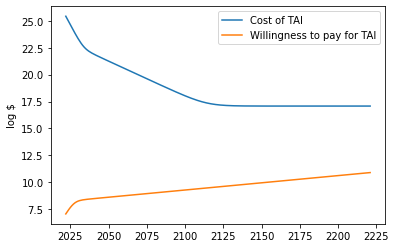

-
-
-
-
############
## RUN 36 ##
############
Anchor debug:
-- Assume human brain in inference takes 20.4 log FLOP (i.e., 10^20.4 FLOP)
-- Add 1.3 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.632
-- Assume FLOPs per param per sec of 1.5
-- 39.8 = 20.4 + 1.3 + 0.3 + 0 + 12 - 0.632 * 11.2 + 0.632 * (20.4 + 1.3 - 1.5)
-- 39.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 39.8 log FLOPs (~7 million decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 5.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.7x per year to a max of 1e-05% of GDP. GDP grows at a rate of 1.021x per 

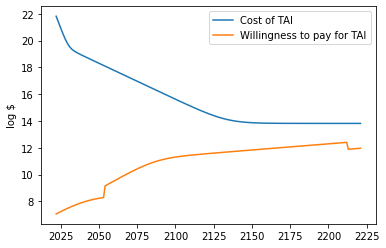

-
-
-
-
############
## RUN 37 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.8 log FLOP (i.e., 10^17.8 FLOP)
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.719
-- Assume FLOPs per param per sec of 1.3
-- 36.3 = 17.8 + 2.0 + -0.6 + 0 + 12 - 0.719 * 11.2 + 0.719 * (17.8 + 2.0 - 1.3)
-- 36.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 36.3 log FLOPs (~2 thousand decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.0x per year to a max of 0.00072% of GDP. GDP grows at a rate of 1.022x

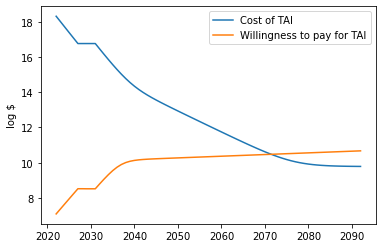

2092: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 38 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.6 log FLOP (i.e., 10^14.6 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -1.0 log FLOP compared to human
-- Assume a horizon length of 4.6
-- Assume a scaling exponent of 1.685
-- Assume FLOPs per param per sec of 1.9
-- 38.3 = 14.6 + 2.1 + -1.0 + 4.6 + 12 - 1.685 * 11.2 + 1.685 * (14.6 + 2.1 - 1.9)
-- 38.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 38.3 log FLOPs (~210 thousand decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and th

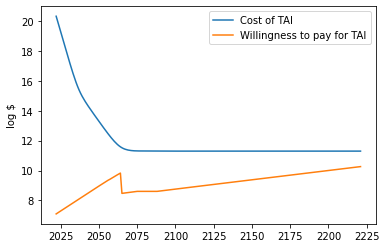

-
-
-
-
############
## RUN 39 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.7 log FLOP (i.e., 10^15.7 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 8.3
-- Assume a scaling exponent of 1.513
-- Assume FLOPs per param per sec of 1.4
-- 46.4 = 15.7 + 2.1 + 0.3 + 8.3 + 12 - 1.513 * 11.2 + 1.513 * (15.7 + 2.1 - 1.4)
-- 46.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 46.4 log FLOPs (~28 trillion decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.0x per year to a max of 0.0009% of GDP. GDP grows at a rate of 1.03

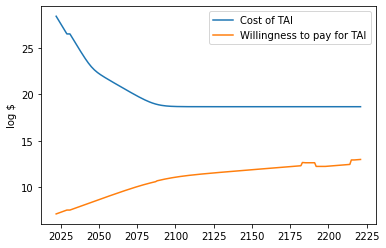

-
-
-
-
############
## RUN 40 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.7 log FLOP (i.e., 10^13.7 FLOP)
-- Add 1.1 log FLOP for efficiency
-- Assume a transformative model takes 0.2 log FLOP compared to human
-- Assume a horizon length of 6.4
-- Assume a scaling exponent of 0.981
-- Assume FLOPs per param per sec of 1.4
-- 35.4 = 13.7 + 1.1 + 0.2 + 6.4 + 12 - 0.981 * 11.2 + 0.981 * (13.7 + 1.1 - 1.4)
-- 35.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 35.4 log FLOPs (~255 decillion) for transformative capabilities.
Every 2.4 years algorithms get 2x better, with 1.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.6 log 2022$USD (~408 million) and this increases by 3.5x per year to a max of 3e-05% of GDP. GDP grows at a rate of 1.03x per ye

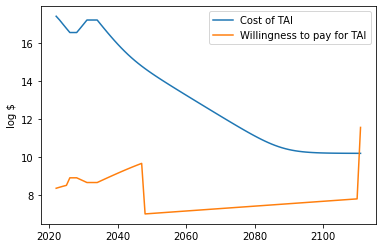

2111: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 41 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.8 log FLOP (i.e., 10^16.8 FLOP)
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 8.4
-- Assume a scaling exponent of 0.653
-- Assume FLOPs per param per sec of 1.5
-- 43.8 = 16.8 + 2.5 + -0.2 + 8.4 + 12 - 0.653 * 11.2 + 0.653 * (16.8 + 2.5 - 1.5)
-- 43.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 43.8 log FLOPs (~61 billion decillion) for transformative capabilities.
Every 0.9 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.4 log 2022$USD (~270 million) and thi

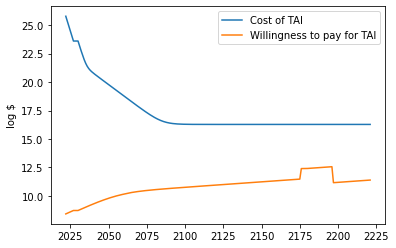

-
-
-
-
############
## RUN 42 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.8 log FLOP (i.e., 10^14.8 FLOP)
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes -1.4 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.318
-- Assume FLOPs per param per sec of 1.7
-- 32.4 = 14.8 + 2.0 + -1.4 + 0 + 12 - 1.318 * 11.2 + 1.318 * (14.8 + 2.0 - 1.7)
-- 32.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 32.4 log FLOPs (~281 nonillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.5x per year to a max of 0.00078% of GDP. GDP grows at a rate of 1.027x per ye

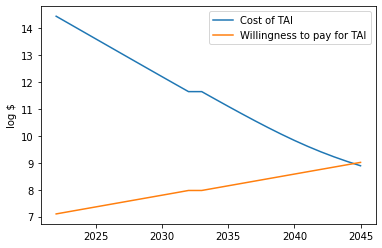

2045: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 43 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.9 log FLOP (i.e., 10^15.9 FLOP)
-- Add 2.2 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.533
-- Assume FLOPs per param per sec of 1.5
-- 37.9 = 15.9 + 2.2 + -0.5 + 0 + 12 - 1.533 * 11.2 + 1.533 * (15.9 + 2.2 - 1.5)
-- 37.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 37.9 log FLOPs (~79 thousand decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this in

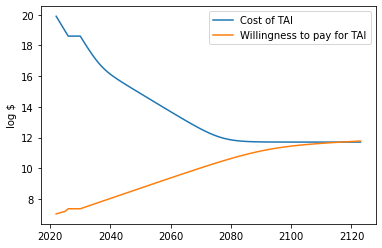

2123: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 44 ##
############
Anchor debug:
-- Assume human brain in inference takes 22.0 log FLOP (i.e., 10^22.0 FLOP)
-- Add 2.9 log FLOP for efficiency
-- Assume a transformative model takes -1.0 log FLOP compared to human
-- Assume a horizon length of 7.5
-- Assume a scaling exponent of 0.867
-- Assume FLOPs per param per sec of 1.3
-- 54.1 = 22.0 + 2.9 + -1.0 + 7.5 + 12 - 0.867 * 11.2 + 0.867 * (22.0 + 2.9 - 1.3)
-- 54.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 54.1 log FLOPs (~1 sextillion decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 4.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and th

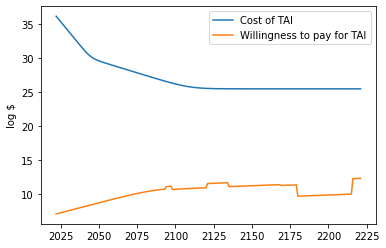

-
-
-
-
############
## RUN 45 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.5 log FLOP (i.e., 10^15.5 FLOP)
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.155
-- Assume FLOPs per param per sec of 1.6
-- 33.8 = 15.5 + 1.7 + -0.5 + 0 + 12 - 1.155 * 11.2 + 1.155 * (15.5 + 1.7 - 1.6)
-- 33.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 33.8 log FLOPs (~7 decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.7x per year to a max of 0.0% of GDP. GDP grows at a rate of 1.026x per year.
If

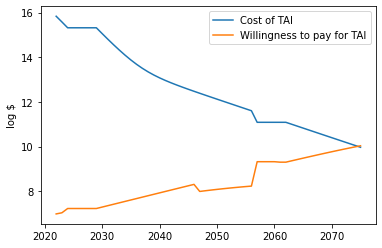

2075: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 46 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.6 log FLOP (i.e., 10^14.6 FLOP)
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -1.0 log FLOP compared to human
-- Assume a horizon length of 4.3
-- Assume a scaling exponent of 1.167
-- Assume FLOPs per param per sec of 1.3
-- 37.0 = 14.6 + 2.1 + -1.0 + 4.3 + 12 - 1.167 * 11.2 + 1.167 * (14.6 + 2.1 - 1.3)
-- 37.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 37.0 log FLOPs (~10 thousand decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and thi

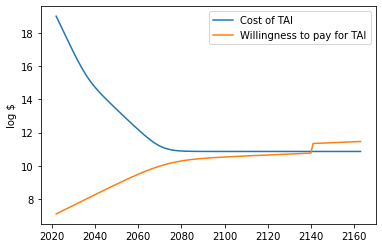

2163: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 47 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.1 log FLOP (i.e., 10^11.1 FLOP)
-- Add 2.4 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 1.5
-- Assume a scaling exponent of 0.545
-- Assume FLOPs per param per sec of 1.4
-- 27.0 = 11.1 + 2.4 + -0.5 + 1.5 + 12 - 0.545 * 11.2 + 0.545 * (11.1 + 2.4 - 1.4)
-- 27.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 27.0 log FLOPs (~964 septillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 3.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.9 log 2022$USD (~72 million) and this incre

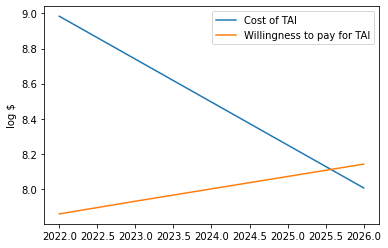

2026: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 48 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.2 log FLOP (i.e., 10^13.2 FLOP)
-- Add 2.6 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.924
-- Assume FLOPs per param per sec of 1.3
-- 30.2 = 13.2 + 2.6 + -0.6 + 0 + 12 - 0.924 * 11.2 + 0.924 * (13.2 + 2.6 - 1.3)
-- 30.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 30.2 log FLOPs (~2 nonillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases 

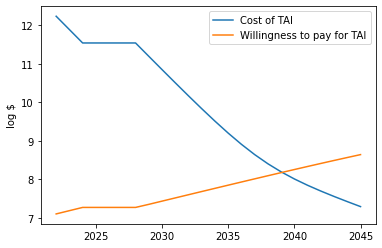

2045: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
-
-
############
## RUN 49 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.5 log FLOP (i.e., 10^12.5 FLOP)
-- Add 2.3 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.507
-- Assume FLOPs per param per sec of 1.4
-- 27.2 = 12.5 + 2.3 + -0.7 + 0 + 12 - 0.507 * 11.2 + 0.507 * (12.5 + 2.3 - 1.4)
-- 27.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 27.2 log FLOPs (~2 octillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.5 log 2022$USD (~342 million) and this increases b

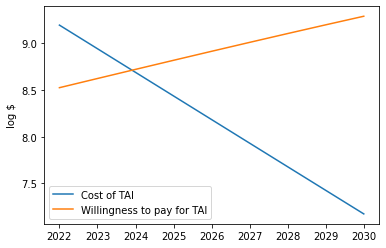

2030: ...Achieved aligned TAI (aligned by default), happy future! :D
-
-
-
-
############
## RUN 50 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.5 log FLOP (i.e., 10^16.5 FLOP)
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.849
-- Assume FLOPs per param per sec of 1.2
-- 31.7 = 16.5 + 0 + -0.2 + 0 + 12 - 0.849 * 11.2 + 0.849 * (16.5 + 0 - 1.2)
-- 31.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
(Note: `log` refers to `log10`)
It takes 31.7 log FLOPs (~56 nonillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 1.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.6x per year to 

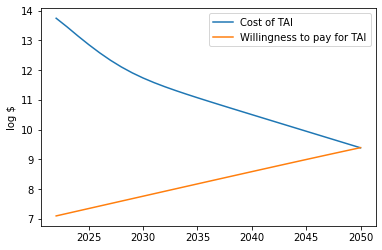

2050: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-


In [18]:
for i in range(50):
    print('-')
    print('-')
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(verbosity=2)

In [19]:
collectors = bayes.bayesnet(define_event,
                            find=lambda e: e['collectors'],
                            load_cache_file='future_assessment_model_cache',
                            dump_cache_file='future_assessment_model_cache',
                            raw=True,
                            verbose=True,
                            n=RUNS)

Loading from cache file...
...Cached data found. Using it.
Caching in-memory...
...Cached
Writing cache to file `future_assessment_model_cache.sqcache.pkl`...
...Cached


In [20]:
def print_states(states):
    c = Counter(states)
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c


print('0. World State At Year')
for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c)) 
    pprint(print_states([c[y_c]['category'] for c in collectors]))
    print('-')
    print('-')

0. World State At Year
## 2030 ##
[('boring', 97.246),
 ('xrisk_full_unaligned_tai_singleton', 1.028),
 ('xrisk_full_unaligned_tai_extinction', 0.666),
 ('aligned_tai', 0.61),
 ('xrisk_tai_misuse', 0.206),
 ('xrisk_subtly_unaligned_tai', 0.129),
 ('xrisk_nukes_war', 0.078),
 ('xrisk_nukes_accident', 0.02),
 ('xrisk_unknown_unknown', 0.012),
 ('xrisk_bio_accident', 0.004),
 ('xrisk_bio_nonstate', 0.001),
 ('xrisk_nanotech', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2050 ##
[('boring', 75.342),
 ('aligned_tai', 11.388),
 ('xrisk_full_unaligned_tai_singleton', 5.589),
 ('xrisk_full_unaligned_tai_extinction', 3.718),
 ('xrisk_subtly_unaligned_tai', 2.135),
 ('xrisk_tai_misuse', 1.465),
 ('xrisk_nukes_war', 0.211),
 ('xrisk_nukes_accident', 0.087),
 ('xrisk_unknown_unknown', 0.04),
 ('xrisk_bio_accident', 0.019),
 ('xrisk_nanotech', 0.004),
 ('xrisk_bio_nonstate', 0.002),
 ('xrisk_bio_war', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2070 ##
[('boring', 59.072),
 ('

In [21]:
print('0B. Catastrophe States At Year')

def print_catastrophe(catastrophes):
    c = Counter([' '.join(sorted(c)) for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

0B. Catastrophe States At Year
## 2023 ##
[('', 99.51),
 ('nukes_war', 0.13),
 ('natural_pathogen', 0.12),
 ('engineered_pathogen', 0.1)]
-
-
## 2030 ##
[('', 95.3),
 ('nukes_war', 1.43),
 ('xrisk_full_unaligned_tai_singleton', 0.82),
 ('xrisk_full_unaligned_tai_extinction', 0.67),
 ('engineered_pathogen', 0.58),
 ('natural_pathogen', 0.44),
 ('nukes_accident', 0.39),
 ('xrisk_tai_misuse', 0.17),
 ('averting_misaligned_tai', 0.1)]
-
-
## 2050 ##
[('', 82.03),
 ('xrisk_full_unaligned_tai_singleton', 4.38),
 ('xrisk_full_unaligned_tai_extinction', 3.65),
 ('nukes_war', 3.28),
 ('engineered_pathogen', 1.65),
 ('nukes_accident', 1.28),
 ('xrisk_tai_misuse', 1.14),
 ('natural_pathogen', 1.11),
 ('averting_misaligned_tai', 0.61),
 ('nukes_war nukes_war', 0.11)]
-
-
## 2070 ##
[('', 76.67),
 ('xrisk_full_unaligned_tai_singleton', 5.78),
 ('xrisk_full_unaligned_tai_extinction', 4.83),
 ('nukes_war', 3.6),
 ('engineered_pathogen', 2.26),
 ('natural_pathogen', 1.51),
 ('nukes_accident', 1.49),
 

In [22]:
print('0C. *First* Catastrophe State At Year')

def print_catastrophe_first(catastrophes):
    c = Counter([c[0] if len(c) > 0 else '' for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

0C. *First* Catastrophe State At Year
## 2023 ##
[('', 99.51),
 ('nukes_war', 0.13),
 ('natural_pathogen', 0.12),
 ('engineered_pathogen', 0.1)]
-
-
## 2030 ##
[('', 95.3),
 ('nukes_war', 1.47),
 ('xrisk_full_unaligned_tai_singleton', 0.82),
 ('xrisk_full_unaligned_tai_extinction', 0.67),
 ('engineered_pathogen', 0.59),
 ('natural_pathogen', 0.45),
 ('nukes_accident', 0.4),
 ('xrisk_tai_misuse', 0.17),
 ('averting_misaligned_tai', 0.1)]
-
-
## 2050 ##
[('', 82.03),
 ('xrisk_full_unaligned_tai_singleton', 4.38),
 ('xrisk_full_unaligned_tai_extinction', 3.65),
 ('nukes_war', 3.61),
 ('engineered_pathogen', 1.78),
 ('nukes_accident', 1.42),
 ('natural_pathogen', 1.2),
 ('xrisk_tai_misuse', 1.14),
 ('averting_misaligned_tai', 0.63),
 ('averting_intentional_tai', 0.1)]
-
-
## 2070 ##
[('', 76.67),
 ('xrisk_full_unaligned_tai_singleton', 5.78),
 ('xrisk_full_unaligned_tai_extinction', 4.83),
 ('nukes_war', 4.26),
 ('engineered_pathogen', 2.53),
 ('nukes_accident', 1.78),
 ('natural_pathogen'

In [23]:
print('0D. Double Catastrophe X-Risks')

def print_double_catastrophes(catastrophes):
    c = Counter(['' if c is None else c for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_double_catastrophes([c[y_c]['double_catastrophe_xrisk'] for c in collectors]))
    print('-')
    print('-')

0D. Double Catastrophe X-Risks
## 2030 ##
[('', 99.997),
 ('nukes_war->nukes_war', 0.001),
 ('nukes_war->nukes_accident', 0.001),
 ('natural_pathogen->natural_pathogen', 0.001)]
-
-
## 2050 ##
[('', 99.971),
 ('nukes_war->nukes_war', 0.01),
 ('nukes_war->nukes_accident', 0.004),
 ('nukes_war->engineered_pathogen', 0.003),
 ('engineered_pathogen->nukes_war', 0.003),
 ('nukes_accident->nukes_accident', 0.002),
 ('natural_pathogen->natural_pathogen', 0.002),
 ('engineered_pathogen->engineered_pathogen', 0.001),
 ('natural_pathogen->nukes_accident', 0.001),
 ('nukes_accident->nukes_war', 0.001),
 ('nukes_accident->engineered_pathogen', 0.001),
 ('nukes_war->natural_pathogen', 0.001)]
-
-
## 2070 ##
[('', 99.963),
 ('nukes_war->nukes_war', 0.013),
 ('nukes_war->nukes_accident', 0.005),
 ('nukes_war->engineered_pathogen', 0.003),
 ('engineered_pathogen->nukes_war', 0.003),
 ('nukes_accident->nukes_accident', 0.003),
 ('engineered_pathogen->nukes_accident', 0.002),
 ('natural_pathogen->natura

In [24]:
print('0E. # of Catastrophes At Year')

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## # of catastrophes as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['catastrophe']) for c in collectors]))
    print('-')
    print('-')

0E. # of Catastrophes At Year
## # of catastrophes as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 1.0}
-
-
## # of catastrophes as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-


In [25]:
print('0F. War States At Year')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / RUNS * 100, 3)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    return bs

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_wars([c[y_c]['wars'] for c in collectors]))
    print('-')
    print('-')

0F. War States At Year
## 2030 ##
[('', 56.565),
 ('US/China', 33.244),
 ('US/Russia', 8.408),
 ('US/China US/China', 0.69),
 ('Other', 0.662),
 ('US/China US/Russia', 0.408),
 ('Other US/China', 0.02),
 ('Other Other', 0.001),
 ('US/China US/China US/Russia', 0.001),
 ('US/China US/China US/China', 0.001)]
-
-
## 2050 ##
[('US/China', 42.09),
 ('', 40.072),
 ('US/Russia', 10.667),
 ('US/China US/China', 2.673),
 ('Other', 2.618),
 ('US/China US/Russia', 1.209),
 ('Other US/China', 0.449),
 ('Other US/Russia', 0.075),
 ('US/Russia US/Russia', 0.055),
 ('US/China US/China US/China', 0.043),
 ('US/China US/China US/Russia', 0.018),
 ('Other US/China US/Russia', 0.009),
 ('Other US/China US/China', 0.009),
 ('Other Other', 0.005),
 ('US/China US/China US/China US/China', 0.004),
 ('US/China US/Russia US/Russia', 0.002),
 ('US/China US/China US/China US/China US/China', 0.001),
 ('Other Other US/China', 0.001)]
-
-
## 2070 ##
[('US/China', 40.351),
 ('', 35.744),
 ('US/Russia', 12.069),
 (

In [26]:
print('0G. War Length States At Year')

def print_wars(y, wars):
    bs = [[(w['end_year'] - w['start_year'] if w['end_year'] < y else y - w['start_year']) if w != [] else 0 for w in ws] for ws in wars]
    bs = [round(sum(b) / (y - CURRENT_YEAR) * 100, 1) for b in bs]
    return bs

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## Percent of time in war as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles(print_wars(y_c, [c[y_c]['wars'] for c in collectors])))
    print('-')
    print('-')

0G. War Length States At Year
## Percent of time in war as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 25.0,
 80: 50.0,
 90: 75.0,
 95: 75.0,
 99: 87.5}
-
-
## Percent of time in war as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 14.3,
 60: 25.0,
 70: 35.7,
 80: 57.1,
 90: 75.0,
 95: 85.7,
 99: 96.4}
-
-
## Percent of time in war as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 6.2,
 50: 10.4,
 60: 16.7,
 70: 25.0,
 80: 35.4,
 90: 56.2,
 95: 77.1,
 99: 95.8}
-
-
## Percent of time in war as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 5.1,
 50: 9.0,
 60: 12.8,
 70: 17.9,
 80: 25.6,
 90: 39.7,
 95: 55.1,
 99: 89.7}
-
-
## Percent of time in war as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 1.7,
 40: 3.4,
 50: 5.6,
 60: 7.9,
 70: 11.2,
 80: 15.7,
 90: 23.6,
 95: 32.6,
 99: 56.7}
-
-


In [27]:
print('0H. # of Wars At Year')

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## # of wars as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['wars']) for c in collectors]))
    print('-')
    print('-')

0H. # of Wars At Year
## # of wars as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 2.0,
 99: 2.0}
-
-
## # of wars as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 2.0,
 95: 2.0,
 99: 2.0}
-
-
## # of wars as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 2.0,
 90: 2.0,
 95: 3.0,
 99: 4.0}
-
-


In [28]:
print('1. Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['engineered_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

1. Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 1.93%
2050 - 5.77%
2100 - 10.69%


In [29]:
print('2. Non-Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['natural_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))    

2. Non-Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 1.44%
2050 - 3.87%
2100 - 7.07%


In [30]:
print('2B. Pathogen Catastrophic Risk (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'pathogen' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


2B. Pathogen Catastrophic Risk (10%+ death)
2030 - 1.06%
2050 - 3.09%
2100 - 5.77%


In [31]:
print('2C. Pathogen Extinction Risk')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk_bio' in e['collectors'][y_c]['category'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))
    

2C. Pathogen Extinction Risk
2030 - 0.005%
2050 - 0.021%
2100 - 0.033%


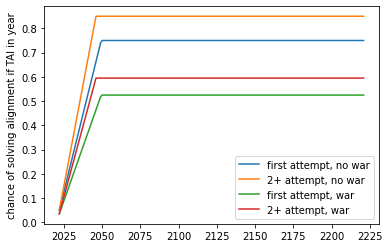

In [32]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
alignment_pwar = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2war = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt, no war')
plt.plot(years, alignment_p2, label='2+ attempt, no war')
plt.plot(years, alignment_pwar, label='first attempt, war')
plt.plot(years, alignment_p2war, label='2+ attempt, war')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
plt.show()


In [33]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with no war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_p[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment with no war 5.0% (2nd attempt 5.0%)
Year: 2023 - chance of solving TAI alignment with no war 8.0% (2nd attempt 8.0%)
Year: 2024 - chance of solving TAI alignment with no war 10.0% (2nd attempt 12.0%)
Year: 2025 - chance of solving TAI alignment with no war 13.0% (2nd attempt 15.0%)
Year: 2026 - chance of solving TAI alignment with no war 15.0% (2nd attempt 18.0%)
Year: 2027 - chance of solving TAI alignment with no war 18.0% (2nd attempt 22.0%)
Year: 2028 - chance of solving TAI alignment with no war 20.0% (2nd attempt 25.0%)
Year: 2029 - chance of solving TAI alignment with no war 23.0% (2nd attempt 28.0%)
Year: 2030 - chance of solving TAI alignment with no war 25.0% (2nd attempt 32.0%)
Year: 2031 - chance of solving TAI alignment with no war 28.0% (2nd attempt 35.0%)
Year: 2032 - chance of solving TAI alignment with no war 31.0% (2nd attempt 38.0%)
Year: 2033 - chance of solving TAI alignment with no war 33.0% (2nd attempt 42.0%)
Year: 20

In [34]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_pwar[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2war[y - CURRENT_YEAR] * 100, 0)))


Year: 2022 - chance of solving TAI alignment with war 3.0% (2nd attempt 3.0%)
Year: 2023 - chance of solving TAI alignment with war 5.0% (2nd attempt 6.0%)
Year: 2024 - chance of solving TAI alignment with war 7.0% (2nd attempt 8.0%)
Year: 2025 - chance of solving TAI alignment with war 9.0% (2nd attempt 11.0%)
Year: 2026 - chance of solving TAI alignment with war 11.0% (2nd attempt 13.0%)
Year: 2027 - chance of solving TAI alignment with war 12.0% (2nd attempt 15.0%)
Year: 2028 - chance of solving TAI alignment with war 14.0% (2nd attempt 18.0%)
Year: 2029 - chance of solving TAI alignment with war 16.0% (2nd attempt 20.0%)
Year: 2030 - chance of solving TAI alignment with war 18.0% (2nd attempt 22.0%)
Year: 2031 - chance of solving TAI alignment with war 20.0% (2nd attempt 24.0%)
Year: 2032 - chance of solving TAI alignment with war 21.0% (2nd attempt 27.0%)
Year: 2033 - chance of solving TAI alignment with war 23.0% (2nd attempt 29.0%)
Year: 2034 - chance of solving TAI alignment wi

In [35]:
print('3. AI Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'tai' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

3. AI Catastrophic Risk* (10%+ death)
2030 - 1.78%
2050 - 10.13%
2100 - 16.12%


In [36]:
print('4. AI Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_full_unaligned_tai_extinction',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


4. AI Extinction Risk*
2030 - 0.67%
2050 - 3.72%
2100 - 5.98%


In [37]:
print('4B. AI X-Risk')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4B. AI X-Risk
2024 - 0.2% (Extinction: 0.1%, Bad TAI singleton: 0.1%, Subtly misaligned singleton: 0.0%, Misuse singleton: 0.0%)
2030 - 2.0% (Extinction: 0.7%, Bad TAI singleton: 1.0%, Subtly misaligned singleton: 0.1%, Misuse singleton: 0.2%)
2050 - 12.9% (Extinction: 3.7%, Bad TAI singleton: 5.6%, Subtly misaligned singleton: 2.1%, Misuse singleton: 1.5%)
2070 - 18.4% (Extinction: 5.0%, Bad TAI singleton: 7.5%, Subtly misaligned singleton: 4.0%, Misuse singleton: 1.9%)
2100 - 22.4% (Extinction: 6.0%, Bad TAI singleton: 8.9%, Subtly misaligned singleton: 5.3%, Misuse singleton: 2.2%)
2200 - 25.4% (Extinction: 6.7%, Bad TAI singleton: 9.9%, Subtly misaligned singleton: 6.2%, Misuse singleton: 2.6%)


In [38]:
# “P(misalignment x-risk|AGI)”: Conditional on AGI being developed by 2070, humanity will go extinct or
# drastically curtail its future potential due to loss of control of AGI

print('4C. AI X-Risk conditional on AGI by 2070')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          conditional_on=lambda e: e['final_state']['tai_year'] <= 2070 if e['final_state']['tai_year'] is not None else False,
                          n=RUNS)

for y_c in [2070, 2100]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4C. AI X-Risk conditional on AGI by 2070
2070 - 38.9% (Extinction: 10.6%, Bad TAI singleton: 15.8%, Subtly misaligned singleton: 8.4%, Misuse singleton: 4.0%)
2100 - 38.9% (Extinction: 10.6%, Bad TAI singleton: 15.8%, Subtly misaligned singleton: 8.4%, Misuse singleton: 4.0%)


In [39]:
print('4D. Aligned TAI')
for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

4D. Aligned TAI
2024 - 0.04%
2030 - 0.61%
2050 - 11.39%
2070 - 22.01%
2100 - 29.61%
2200 - 34.89%


In [40]:
print('4E. When TAI?')
print('-')

yrs = bayes.bayesnet(define_event,
                     find=lambda e: e['final_state']['tai_year'],
                     raw=True,
                     n=RUNS)
pprint(sq.get_percentiles([2223 if yr is None else yr for yr in yrs]))
print('-')

def bin_tai_yrs(low=None, hi=None):
    low = CURRENT_YEAR if low is None else low
    if hi is None:
        r = bayes.bayesnet(define_event,
                           find=lambda e: e['final_state']['tai_year'] is None or e['final_state']['tai_year'] >= low,
                           n=RUNS)
    else:
        r = bayes.bayesnet(define_event,
                           find=lambda e: (e['final_state']['tai_year'] is not None and
                                          (e['final_state']['tai_year'] >= low and e['final_state']['tai_year'] <= hi)),
                           n=RUNS)
    return round(r * 100, 1)

print('<2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('2025-2029: {}%'.format(bin_tai_yrs(2025, 2029)))
print('2030-2039: {}%'.format(bin_tai_yrs(2030, 2039)))
print('2040-2049: {}%'.format(bin_tai_yrs(2040, 2049)))
print('2050-2059: {}%'.format(bin_tai_yrs(2050, 2059)))
print('2060-2069: {}%'.format(bin_tai_yrs(2060, 2069)))
print('2070-2079: {}%'.format(bin_tai_yrs(2070, 2079)))
print('2080-2089: {}%'.format(bin_tai_yrs(2080, 2089)))
print('2090-2099: {}%'.format(bin_tai_yrs(2090, 2099)))
print('2100-2149: {}%'.format(bin_tai_yrs(2100, 2149)))
print('2149-2199: {}%'.format(bin_tai_yrs(2149, 2199)))
print('>2200: {}%'.format(bin_tai_yrs(low=2220)))
print('-')

print('By EOY 2023: {}%'.format(bin_tai_yrs(hi=2023)))
print('By EOY 2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('By EOY 2025: {}%'.format(bin_tai_yrs(hi=2025)))
print('By EOY 2030: {}% (Ajeya 2022: 15%)'.format(bin_tai_yrs(hi=2030)))
print('By EOY 2032: {}% (within 10yrs)'.format(bin_tai_yrs(hi=2032)))
print('By EOY 2036: {}% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)'.format(bin_tai_yrs(hi=2036)))
print('By EOY 2040: {}% (Ajeya 2022: 50%)'.format(bin_tai_yrs(hi=2040)))
print('By EOY 2042: {}% (FTX: 20%, 10%-45%)'.format(bin_tai_yrs(hi=2042)))
print('By EOY 2047: {}% (within 25yrs)'.format(bin_tai_yrs(hi=2047)))
print('By EOY 2050: {}% (Ajeya 2020: 50%, Ajeya 2022: 60%)'.format(bin_tai_yrs(hi=2050)))
print('By EOY 2060: {}% (Holden benchmark - 25%-75%, Holden: 50%)'.format(bin_tai_yrs(hi=2060)))
print('By EOY 2070: {}% (Carlsmith: 50%)'.format(bin_tai_yrs(hi=2070)))
print('By EOY 2072: {}% (within 50yrs)'.format(bin_tai_yrs(hi=2072)))
print('By EOY 2078: {}% (within my expected lifetime)'.format(bin_tai_yrs(hi=2078)))
print('By EOY 2099: {}% (FTX: 60%, >30%)'.format(bin_tai_yrs(hi=2099)))
print('By EOY 2100: {}% (Holden benchmark - 33%-90%, Holden: 66%)'.format(bin_tai_yrs(hi=2100)))
print('By EOY 2122: {}% (within 100yrs)'.format(bin_tai_yrs(hi=2122)))
print('By EOY 2222: {}% (within 200yrs)'.format(bin_tai_yrs(hi=2222)))


4E. When TAI?
-
{1: 2026.0,
 5: 2033.0,
 10: 2037.0,
 20: 2044.0,
 30: 2051.0,
 40: 2061.0,
 50: 2074.0,
 60: 2097.0,
 70: 2195.0,
 80: 2223.0,
 90: 2223.0,
 95: 2223.0,
 99: 2223.0}
-
<2024: 0.3%
2025-2029: 2.3%
2030-2039: 10.6%
2040-2049: 14.4%
2050-2059: 10.9%
2060-2069: 8.3%
2070-2079: 6.2%
2080-2089: 4.4%
2090-2099: 3.1%
2100-2149: 6.4%
2149-2199: 3.3%
>2200: 28.7%
-
By EOY 2023: 0.2%
By EOY 2024: 0.3%
By EOY 2025: 0.6%
By EOY 2030: 3.3% (Ajeya 2022: 15%)
By EOY 2032: 4.8% (within 10yrs)
By EOY 2036: 9.0% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)
By EOY 2040: 14.7% (Ajeya 2022: 50%)
By EOY 2042: 17.8% (FTX: 20%, 10%-45%)
By EOY 2047: 25.0% (within 25yrs)
By EOY 2050: 28.9% (Ajeya 2020: 50%, Ajeya 2022: 60%)
By EOY 2060: 39.4% (Holden benchmark - 25%-75%, Holden: 50%)
By EOY 2070: 47.5% (Carlsmith: 50%)
By EOY 2072: 48.9% (within 50yrs)
By EOY 2078: 52.5% (within my expected lifetime)
By EOY 2099: 60.6% (FTX: 60%, >30%)
By EOY 2100: 60.8% (Holden benchmark - 33%-90

In [41]:
print('5. Nuclear Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'nukes' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

5. Nuclear Catastrophic Risk* (10%+ death)
2030 - 1.88%
2050 - 5.14%
2100 - 7.24%


In [42]:
print('6. Nuclear Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    war = find(y_c, 'xrisk_nukes_war')
    accident = find(y_c, 'xrisk_nukes_accident')
    print('{} - {}% (war: {}%, accident: {}%)'.format(y_c,
                                                      round((war + accident) * 100, 3),
                                                      round(war * 100, 3),
                                                      round(accident * 100, 3)))
    

6. Nuclear Extinction Risk*
2030 - 0.098% (war: 0.078%, accident: 0.02%)
2050 - 0.298% (war: 0.211%, accident: 0.087%)
2100 - 0.46% (war: 0.305%, accident: 0.155%)
2200 - 0.643% (war: 0.43%, accident: 0.213%)


In [43]:
print('7. Non-Anthropogenic Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'supervolcano' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))
    
# NOTE: All other sources < 0.01%


7. Non-Anthropogenic Catastrophic Risk* (10%+ death)
2030 - 0.001%
2050 - 0.004%
2100 - 0.009%


In [44]:
print('8. Non-Anthropogenic Extinction Risk*')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_supervolcano',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 4)))

# NOTE: All other sources < 0.01%


8. Non-Anthropogenic Extinction Risk*
2030 - 0.0%
2050 - 0.0%
2100 - 0.0%


In [45]:
print('9. Total Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

9. Total Catastrophic Risk* (10%+ death)
2030 - 4.7%
2050 - 17.96%
2100 - 27.56%


In [46]:
print('10. Total Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    ai = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    nukes_war = find(y_c, 'xrisk_nukes_war')
    nukes_accident = find(y_c, 'xrisk_nukes_accident')
    unknown = find(y_c, 'xrisk_unknown_unknown')
    bio_war = find(y_c, 'xrisk_bio_war')
    bio_accident = find(y_c, 'xrisk_bio_accident')
    bio_nonstate = find(y_c, 'xrisk_bio_nonstate')
    nanotech = find(y_c, 'xrisk_nanotech')
    supervolcano = find(y_c, 'xrisk_supervolcano')
    
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] in extinctions,
                       n=RUNS)
    
    out = '{} - {}% (AI: {}%, Nukes: {}% (War: {}% Accident: {}%), Bio: {}% (War: {}%, Accident: {}%, Nonstate: {}%), Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round(r * 100, 2),
                     round(ai * 100, 2),
                     round((nukes_war + nukes_accident) * 100, 3),
                     round(nukes_war * 100, 3),
                     round(nukes_accident * 100, 3),
                     round((bio_war + bio_accident + bio_nonstate) * 100, 3),
                     round(bio_war * 100, 3),
                     round(bio_accident * 100, 3),
                     round(bio_nonstate * 100, 3),
                     round(nanotech * 100, 3),
                     round(supervolcano * 100, 3),
                     round(unknown * 100, 3)))
        

10. Total Extinction Risk*
2030 - 0.78% (AI: 0.67%, Nukes: 0.098% (War: 0.078% Accident: 0.02%), Bio: 0.005% (War: 0.0%, Accident: 0.004%, Nonstate: 0.001%), Nano: 0.0%, Natural: 0.0%, Other: 0.012%)
2050 - 4.08% (AI: 3.72%, Nukes: 0.298% (War: 0.211% Accident: 0.087%), Bio: 0.021% (War: 0.0%, Accident: 0.019%, Nonstate: 0.002%), Nano: 0.004%, Natural: 0.0%, Other: 0.04%)
2100 - 6.59% (AI: 5.98%, Nukes: 0.46% (War: 0.305% Accident: 0.155%), Bio: 0.033% (War: 0.0%, Accident: 0.026%, Nonstate: 0.007%), Nano: 0.03%, Natural: 0.0%, Other: 0.092%)
2200 - 7.85% (AI: 6.65%, Nukes: 0.643% (War: 0.43% Accident: 0.213%), Bio: 0.052% (War: 0.001%, Accident: 0.038%, Nonstate: 0.013%), Nano: 0.242%, Natural: 0.0%, Other: 0.263%)


In [47]:
print('10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2023, 2024, 2030, 2035, 2037, 2040, 2045, 2050, 2060, 2070, 2100, 2200]:
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)
2023 - 0.13% (AI: 0.12%, Nukes: 0.004%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.002%)
2024 - 0.24% (AI: 0.22%, Nukes: 0.018%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.005%)
2030 - 2.14% (AI: 2.03%, Nukes: 0.098%, Bio: 0.005%, Nano: 0.0%, Natural: 0.0%, Other: 0.012%)
2035 - 4.69% (AI: 4.47%, Nukes: 0.185%, Bio: 0.014%, Nano: 0.002%, Natural: 0.0%, Other: 0.019%)
2037 - 5.96% (AI: 5.72%, Nukes: 0.208%, Bio: 0.015%, Nano: 0.002%, Natural: 0.0%, Other: 0.021%)
2040 - 8.01% (AI: 7.73%, Nukes: 0.241%, Bio: 0.017%, Nano: 0.003%, Natural: 0.0%, Other: 0.025%)
2045 - 11.05% (AI: 10.72%, Nukes: 0.279%, Bio: 0.019%, Nano: 0.003%, Natural: 0.0%, Other: 0.032%)
2050 - 13.27% (AI: 12.91%, Nukes: 0.298%, Bio: 0.021%, Nano: 0.004%, Natural: 0.0%, Other: 0.04%)
2060 - 16.48% (AI: 16.08%, Nukes: 0.331%, Bio: 0.023%, Nano: 0.005%, Natural: 0.0%, Other: 0.05%)
2070 - 18.92% (AI: 18

In [48]:
print('10C. Total X-Risk OR catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] or e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


10C. Total X-Risk OR catastrophe
2024 - 0.99%
2030 - 5.16%
2050 - 21.65%
2070 - 29.15%
2100 - 34.82%
2200 - 42.43%


In [49]:
print('10D. Total X-Risk AND catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] and e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


10D. Total X-Risk AND catastrophe
2024 - 0.19%
2030 - 1.69%
2050 - 9.58%
2070 - 13.1%
2100 - 15.78%
2200 - 18.26%


In [50]:
print('11. Year of Extinction*')
rs = bayes.bayesnet(define_event,
                    find=lambda e: (e['final_state']['category'], e['final_state']['final_year']),
                    raw=True,
                    n=RUNS)
extinction_years = [r[1] if r[0] in extinctions else 100000 for r in rs]
pprint(sq.get_percentiles(extinction_years, [5, 25, 50, 75, 95]))


11. Year of Extinction*
{5: 2062.0, 25: 100000.0, 50: 100000.0, 75: 100000.0, 95: 100000.0}


In [51]:
print('12. Future Human Births*')
pop_per_year = sq.lognorm(100*M, 1*B)
populations = [round((y - CURRENT_YEAR) * ~pop_per_year, 0) for y in extinction_years]
sq.get_log_percentiles(populations, [5, 25, 50, 75, 95])


12. Future Human Births*


{5: '10^10.1', 25: '10^13.2', 50: '10^13.5', 75: '10^13.7', 95: '10^14.0'}

In [52]:
print('13. Non-Coronavirus mRNA Vaccine*')

n_in_trials_2024 = sq.lognorm(36000, 36000*3)
n_in_scaled_vaccine = sq.lognorm(2*M, 2*B)
p_scaled_vaccine_by_2024 = 0.03

n_in_trials_2030 = sq.lognorm(108*K, 360*K)
p_scaled_vaccine_by_2030 = 0.1

p_aligned_tai_by_2024 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2024]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2024 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2024]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2024


def sim_2024():
    n = ~n_in_trials_2024
    if sq.event(p_aligned_tai_by_2024):
        return n
    elif sq.event(p_xrisk_by_2024):
        return n / 3
    elif sq.event(p_scaled_vaccine_by_2024):
        return n + ~n_in_scaled_vaccine
    else:
        return n
    # TODO: Delay for catastrophic risks?
    
    
p_aligned_tai_by_2030 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2030]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2030 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2030]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2030

def sim_2030(): # TODO: DRY
    n = ~n_in_trials_2030
    if sq.event(p_aligned_tai_by_2030):
        return n
    elif sq.event(p_xrisk_by_2030):
        return n / 3
    elif sq.event(p_scaled_vaccine_by_2030):
        return n + ~n_in_scaled_vaccine
    else:
        return n
    # TODO: Delay for catastrophic risks?


print('## 2024 ##')
pprint(sq.get_percentiles([sim_2024() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))

print('## 2030 ##')
pprint(sq.get_percentiles([sim_2030() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))


13. Non-Coronavirus mRNA Vaccine*
## 2024 ##
{5: 35902, 25: 49725, 50: 62612, 75: 79100, 95: 120594}
## 2030 ##
{5: 99377, 25: 153260, 50: 202973, 75: 270385, 95: 76552203}


In [53]:
print('31. Nuclear Weapon Use')
for y_c in [2024, 2030]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['nuclear_weapon_used'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

31. Nuclear Weapon Use
2024 - 6.99%
2030 - 14.4%


In [54]:
print('53. GWP >15% by 2100?')
bayes.bayesnet(define_event,
               find=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                              (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               n=RUNS) * 0.7 * 0.9


53. GWP >15% by 2100?


0.1865367

In [55]:
print('53. Year GWP >15% if by 2100')
bayes.bayesnet(define_event,
               find=lambda e: e['final_state']['final_year'],
               conditional_on=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                                         (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               reduce_fn=lambda y: sq.get_percentiles(y, [95, 75, 50, 25, 5]),
               n=RUNS)


53. Year GWP >15% if by 2100


{95: 2092.0, 75: 2071.0, 50: 2056.0, 25: 2045.0, 5: 2034.0}

In [56]:
print('55. Space Colony*')

def p_space_colony_if_boring(year):
    return 1 - (0.998 ** year)

p_space_colony_if_aligned_tai = 0.1

for y_c in [2030, 2050, 2100]:
    p_aligned_tai = bayes.bayesnet(define_event,
                                   find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                                   n=RUNS)
    p_boring = bayes.bayesnet(define_event,
                              find=lambda e: e['collectors'][y_c]['category'] == 'boring',
                              n=RUNS)
    
    print('{} - {} * {} + {} * {} = {}%'.format(y_c,
                                                round(p_boring, 3),
                                                round(p_space_colony_if_boring(y_c - CURRENT_YEAR), 3),
                                                round(p_aligned_tai, 3),
                                                p_space_colony_if_aligned_tai,
                                                round(((p_boring * p_space_colony_if_boring(y_c - CURRENT_YEAR)) +
                                                       (p_aligned_tai * p_space_colony_if_aligned_tai)) * 100, 2)))


55. Space Colony*
2030 - 0.972 * 0.016 + 0.006 * 0.1 = 1.61%
2050 - 0.753 * 0.055 + 0.114 * 0.1 = 5.25%
2100 - 0.473 * 0.145 + 0.296 * 0.1 = 9.81%


In [57]:
# https://forum.effectivealtruism.org/posts/nYgw4FNpHf9bmJGEi/forecasting-thread-how-does-ai-risk-level-vary-based-on

def generate_conditional(y_low, y_high):
    def fn(e):
        if e['final_state']['tai_year'] is None:
            return False
        elif e['final_state']['tai_year'] < y_low:
            return False
        elif e['final_state']['tai_year'] > y_high:
            return False
        else:
            return True
    return fn
    

def find(y_low, y_high, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][MAX_YEAR - 1 if y_high >= MAX_YEAR else y_high]['category'] == category,
                          conditional_on=generate_conditional(y_low, y_high),
                          n=RUNS)


for y_c in [[2021, 2024], [2024, 2029], [2029, 2039], [2039, 2059], [2059, MAX_YEAR - 1]]:
    print('AI X-Risk conditional on AGI beween beginning of {} and end of {}'.format(y_c[0] + 1, y_c[1]))
    extinction = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c[0], y_c[1], 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c[0], y_c[1], 'xrisk_tai_misuse')
    out = '{}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))
    print('-')


AI X-Risk conditional on AGI beween beginning of 2022 and end of 2024
68.1% (Extinction: 24.0%, Bad TAI singleton: 36.0%, Subtly misaligned singleton: 2.8%, Misuse singleton: 5.4%)
-
AI X-Risk conditional on AGI beween beginning of 2025 and end of 2029
63.0% (Extinction: 20.4%, Bad TAI singleton: 32.3%, Subtly misaligned singleton: 4.2%, Misuse singleton: 6.2%)
-
AI X-Risk conditional on AGI beween beginning of 2030 and end of 2039
51.7% (Extinction: 15.7%, Bad TAI singleton: 23.3%, Subtly misaligned singleton: 6.2%, Misuse singleton: 6.5%)
-
AI X-Risk conditional on AGI beween beginning of 2040 and end of 2059
35.0% (Extinction: 8.9%, Bad TAI singleton: 13.5%, Subtly misaligned singleton: 9.0%, Misuse singleton: 3.5%)
-
AI X-Risk conditional on AGI beween beginning of 2060 and end of 2221
30.3% (Extinction: 7.2%, Bad TAI singleton: 10.3%, Subtly misaligned singleton: 9.8%, Misuse singleton: 2.9%)
-
